In [1]:
import pandas as pd
from pandas import option_context

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Tuple, Dict, Union, Optional
import random
random.seed(0)

import re

from generation_exp import get_best_checkpoint

pd.set_option('max_colwidth', 400) # avoid trimming cells
pd.set_option('display.max_columns', None) # avoid truncating columns
pd.set_option('display.max_rows', None) # avoid truncating rows

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
paths = {
    'results': Path('results'),
    'models': Path('resources/models/ft'),
    'plots': Path('results/plots'),
}

models = [
    'bart_small',
    'bart_base',
    't5_small',
    'roberta_base',
]

paths['plots'].mkdir(parents=True, exist_ok=True)

### Inspect generated outputs

In [3]:
def parse_file_stem(stem: str) -> Tuple:
    parts = stem.split('_')
    if parts[-1] != 'tp=0.9':
        return (parts[-1], int(parts[2].split('=')[-1]))
    else:
        return ('default', int(parts[2].split('=')[-1]))
    
# resources/models/ft/bart_small-rl1_mr01_rt1_ps1_in0_pl3_ma03/checkpoint-72620/outputs/generationstest_freq_seed=284_ml=40_lp=1.0_ns=1_bs=4_ds=1_temp=0.7_tk=0_tp=0.9_ctxt=5-questions-10.txt
def quick_lc(file: Union[str, Path]) -> int:
    with open(file, 'rb') as f:
        return sum(1 for line in f)
    
def read_lines(file: Union[str, Path], line_indices: Optional[List[int]]=None) -> List[str]:
    lines = []
    with open(file, 'r', encoding='utf8') as f:
        for i, line in enumerate(f):
            if line_indices and i not in line_indices:
                pass
            else:
                lines.append(line.strip())
    return lines

def sample_line_indices(lc: int, n: int) -> List[int]:
    return random.sample(range(lc), n)
    
def get_outputs_dataframe(model_path: Path, sample_n: int = 10) -> pd.DataFrame:
    checkpoint_dir = get_best_checkpoint(model_path)
    file_list = list((model_path / f'{checkpoint_dir}/outputs').glob('generation*'))
    
    if sample_n > 0:
        expected_lc = quick_lc(file_list[0])
        sample_lines = sample_line_indices(expected_lc, sample_n)
        print(sample_lines)
    else:
        sample_lines = None
    
    d = {}
    for file in file_list:
        d[parse_file_stem(file.stem)] = read_lines(file, sample_lines)
    # load dictionary into dataframe, splitting the key tuple into a multiIndex
    df = pd.DataFrame(d.values(), index=pd.MultiIndex.from_tuples(d.keys(), names=['gen_setting', 'seed']))
    
    df = df.sort_values(by=['gen_setting', 'seed'], ascending=True)
    return df

sampled_outputs = get_outputs_dataframe(paths['models'] / 'bart_small-rl1_mr01_rt1_ps1_in0_pl3_ma03', sample_n=10)
sampled_outputs

[6311, 6890, 663, 4242, 8376, 7961, 6634, 4969, 7808, 5866]


0  \
gen_setting         seed                                                                                                        
ctxt=1-questions-10 0                           I agree. Did you know that the 3 horizontal line menu is called the websites?   
                    42                          I agree. Did you know that the 3 horizontal line menu is called the websites?   
                    284                                 I think it is the 3 horizontal line menu is called a hamburger button   
                    983                         I agree. Did you know that the 3 horizontal line menu is called the websites?   
                    8630                        I agree. Did you know that the 3 horizontal line menu is called the websites?   
ctxt=5-questions-10 0                                I agree. Did you know the 3 horizontal line menu is called the websites?   
                    42                    I agree. Did you know that the 3 horizontal line menu is called a hamburger button?   
                    284   I think that's a lot of money. Did you know that the 3 horizontal line menu is called the websites?   
                    983                         I agree. Did you know that the 3 horizontal line menu is called the websites?   
                    8630                        I agree. Did you know that the 3 horizontal line menu is called the websites?   
default             0                           I agree. Did you know that the 3 horizontal line menu is called the websites?   
                    42                            I agree. Did you know that the 3 horizontal line menu is called a websites?   
                    284                                                 I think it is the 3 horizontal line menu and websites   
                    983                         I agree. Did you know that the 3 horizontal line menu is called the websites?   
                    8630                        I agree. Did you know that the 3 horizontal line menu is called the websites?   
xatt=5-dialog       0                           I agree. Did you know that the 3 horizontal line menu is called the websites?   
                    42                                 I agree. Did you know that the 3 horizontal line menu is called a man?   
                    284     I think that's a lot of money. Did you know that the 3 horizontal line menu is called a websites?   
                    983                           I agree. Did you know that the 3 horizontal line menu is called a websites?   
                    8630                        I agree. Did you know that the 3 horizontal line menu is called the websites?   
xatt=5-knowledge    0                                I agree. Did you know the 3 horizontal line menu is called the websites?   
                    42                               I agree. Did you know the 3 horizontal line menu is called the websites?   
                    284                                       I think the 3 horizontal line menu is called a hamburger button   
                    983                              I agree. Did you know the 3 horizontal line menu is called the websites?   
                    8630                                      I think the 3 horizontal line menu is called a hamburger button   

                                                                                                                                                           1  \
gen_setting         seed                                                                                                                                       
ctxt=1-questions-10 0                                                                             I think it's a lot of money. I wonder why they have a lot.   
                    42                                                      I wonder if they have a lot of football players in football, I think it's a lot.   


### Emprical analysis for question context controlled generation

In [4]:
INDEX_LEVELS = ['model', 'gen_setting', 'seed']

def parse_num(num: str) -> Union[float, int]:
    """custom string->float converter for file name elements"""
    if len(num) > 1:
        if num[0] == '0':
            return float('0.'+num)
    else:
        return float(num)

def parse_denoising_args_from_model_name(model_name: str) -> str:
    """
    expects a model name (e.g. `bart_base`, `bart_small-rl1_mr01_rt1_ps1_in0_pl3_ma03`, etc) 
    and creates a nicer ID string removing any values that differ from the baseline pretraining 
    setting used by BART
    """
    model_name = model_name.split('-')
    if len(model_name) == 1:
        return model_name[0]
    
    model_name, denoising_args = model_name
    denoising_args = re.sub('rl', 'replace_len=', denoising_args)
    denoising_args = re.sub('_mr', ' mask_rand=', denoising_args)
    denoising_args = re.sub('_rt', ' doc_rotation=', denoising_args)
    denoising_args = re.sub('_ps', ' perm_sents=', denoising_args)
    denoising_args = re.sub('_in', ' insert=', denoising_args)
    denoising_args = re.sub('_pl', ' poisson_lambda=', denoising_args)
    denoising_args = re.sub('_ma', ' mask=', denoising_args)
    args = {k: parse_num(v) for k, v in [s.split('=') for s in denoising_args.split()]} # convert all args to dict
    
    baseline_vals = {
        'replace_len': 1.0,
        'mask_rand': 0.01,
        'doc_rotation': 0.0,
        'perm_sents': 1.0,
        'insert': 0.0,
        'poisson_lambda': 3.0,
        'mask': 0.03,
    }
    
    for k, v in sorted(args.items(), key=lambda x:x[0].lower()): # get sorted keys
        if v > baseline_vals.get(k):
            model_name += f'+{k}={baseline_vals.get(k)+v}'
        elif v < baseline_vals.get(k):
            model_name += f'-{k}={baseline_vals.get(k)-v}'
            
    return model_name

def parse_file_stem(file: Path) -> Tuple:
    """parses information from results file name"""
    parts = file.stem.split('-')
    if len(parts) == 2:
        return parts[0], parts[1] # (model name, generation setting)
    else:
        return '-'.join(parts[:-1]), parts[-1] # (model name + pretraining objs, generation setting)
    
def flatten(l: List[List]) -> List:
    """flattens a list of lists"""
    return [item for sublist in l for item in sublist]

def load_results_dataframe(result_file_list: List, verbose: bool = False) -> pd.DataFrame:
    dfs = []
    for file in result_file_list:    
        if verbose:
            print(f'Loading data from {file} ...')
        df = pd.read_csv(file, sep=',', header=0, index_col=None)
        df['model'], df['gen_setting'] = parse_file_stem(file)
        df['file'] = file.stem
        dfs.append(df)

    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    # standardise concatenated dataframe
    df['gen_setting'] = df['gen_setting'].apply(lambda x: 'default' if x == 'baseline' else x) # rename default generation setting
    df['model'] = df['model'].apply(parse_denoising_args_from_model_name) # human readble denoising arguments
    df.set_index(INDEX_LEVELS, inplace=True)
    df = df.sort_values(by=INDEX_LEVELS, ascending=True)
    
    if verbose:
        print(f'\nResults table contains:')
        for col_name in df.columns.to_list():
              print(f'\t{col_name}')
    return df

# print(parse_denoising_args_string('bart_base'))
# print(parse_denoising_args_string('t5_small'))
# print(parse_denoising_args_string('roberta_base'))
# print(parse_denoising_args_string('bart_small-rl1_mr01_rt1_ps1_in0_pl3_ma03'))
# print(parse_denoising_args_string('bart_small-rl1_mr0_rt1_ps1_in0_pl3_ma0'))
# print(parse_denoising_args_string('rl1_mr0_rt0_ps1_in0_pl3_ma0'))

result_file_list = flatten([list(paths['results'].glob(f'{model}*')) for model in models])
df = load_results_dataframe(result_file_list, verbose=True)
df 

Loading data from results/bart_small-rl1_mr0_rt0_ps1_in0_pl3_ma0-qu_ctxt_aug5.csv ...
Loading data from results/bart_small-rl1_mr01_rt0_ps0_in0_pl3_ma03-xa_knowledge.csv ...
Loading data from results/bart_small-rl1_mr01_rt0_ps0_in0_pl3_ma03-baseline.csv ...
Loading data from results/bart_small-rl1_mr0_rt0_ps1_in0_pl3_ma0-xa_knowledge+qu_ctxt_aug5.csv ...
Loading data from results/bart_small-rl1_mr01_rt0_ps1_in0_pl3_ma03-xa_knowledge+qu_ctxt_aug5.csv ...
Loading data from results/bart_small-rl1_mr01_rt0_ps1_in0_pl3_ma03-xa_dialog+qu_ctxt_aug5.csv ...
Loading data from results/bart_small-rl1_mr01_rt1_ps1_in0_pl3_ma03-xa_knowledge.csv ...
Loading data from results/bart_small-rl1_mr0_rt0_ps1_in0_pl3_ma0-xa_dialog+qu_ctxt_aug5.csv ...
Loading data from results/bart_small-rl1_mr01_rt0_ps1_in0_pl3_ma03-xa_knowledge.csv ...
Loading data from results/bart_small-rl1_mr01_rt0_ps1_in0_pl3_ma03-qu_ctxt_aug1.csv ...
Loading data from results/bart_small-rl1_mr01_rt0_ps1_in0_pl3_ma03-qu_ctxt_aug5.csv 

model_name_or_path  \
model                               gen_setting               seed                                                                  
bart_base                           default                   0                                    resources/models/ft/bart_base/   
                                                              42                                   resources/models/ft/bart_base/   
                                                              284                                  resources/models/ft/bart_base/   
                                                              983                                  resources/models/ft/bart_base/   
                                                              8630                                 resources/models/ft/bart_base/   
                                    qu_ctxt_aug1              0                                    resources/models/ft/bart_base/   
                                                              42                                   resources/models/ft/bart_base/   
                                                              284                                  resources/models/ft/bart_base/   
                                                              983                                  resources/models/ft/bart_base/   
                                                              8630                                 resources/models/ft/bart_base/   
                                    qu_ctxt_aug5              0                                    resources/models/ft/bart_base/   
                                                              42                                   resources/models/ft/bart_base/   
                                                              284                                  resources/models/ft/bart_base/   
                                                              983                                  resources/models/ft/bart_base/   
                                                              8630                                 resources/models/ft/bart_base/   
                                    xa_dialog                 0                                    resources/models/ft/bart_base/   
                                                              42                                   resources/models/ft/bart_base/   
                                                              284                                  resources/models/ft/bart_base/   
                                                              983                                  resources/models/ft/bart_base/   
                                                              8630                                 resources/models/ft/bart_base/   
                                    xa_dialog+qu_ctxt_aug5    0                                    resources/models/ft/bart_base/   
                                                              42                                   resources/models/ft/bart_base/   
                                                              284                                  resources/models/ft/bart_base/   
                                                              983                                  resources/models/ft/bart_base/   
                                                              8630                                 resources/models/ft/bart_base/   
                                    xa_knowledge              0                                    resources/models/ft/bart_base/   
                                                              42                                   resources/models/ft/bart_base/   
                                                              284                                  resources/models/ft/bart_base/   
                                                              983                                  resources/models/ft/ba

In [5]:
agg_ops = {
#     'uniq': np.mean, 
#     'qc_turn_level': [np.mean, np.std],
    'qc_sent_level': [np.mean],
    'ppl_mean': [np.mean], 
#     'ppl_std': [np.mean, np.std], 
    'intra_dist1': [np.mean],
#     'intra_dist2': [np.mean],
    'inter_dist1': [np.mean],
#     'inter_dist2': [np.mean],
    'bleu_t': [np.mean],
#     'rouge1_t': [np.mean, np.std],
#     'meteor_t': [np.mean, np.std],
    'bleu_k': [np.mean],
#     'rouge1_k': [np.mean, np.std],
#     'meteor_k': [np.mean, np.std],
    'bleu_d': [np.mean],
#     'rouge1_d': [np.mean, np.std],
#     'meteor_d': [np.mean, np.std],
}

dfa = df.groupby(INDEX_LEVELS[:-1], as_index=True).agg(agg_ops)
dfa = dfa.sort_values(INDEX_LEVELS[:-1], ascending=[1,1])
dfa = dfa.drop(['xa_dialog', 'xa_knowledge'], level=1, axis=0)
dfa

qc_sent_level  \
                                                                       mean   
model                               gen_setting                               
bart_base                           default                        0.256106   
                                    qu_ctxt_aug1                   0.327766   
                                    qu_ctxt_aug5                   0.440353   
                                    xa_dialog+qu_ctxt_aug5         0.351660   
                                    xa_knowledge+qu_ctxt_aug5      0.325074   
bart_small                          default                        0.516735   
                                    qu_ctxt_aug1                   0.561655   
                                    qu_ctxt_aug5                   0.598919   
                                    xa_dialog+qu_ctxt_aug5         0.594418   
                                    xa_knowledge+qu_ctxt_aug5      0.302372   
bart_small+doc_rotation=1.0         default                        0.357617   
                                    qu_ctxt_aug1                   0.414385   
                                    qu_ctxt_aug5                   0.525516   
                                    xa_dialog+qu_ctxt_aug5         0.489686   
                                    xa_knowledge+qu_ctxt_aug5      0.281390   
bart_small-mask=0.03-mask_rand=0.01 default                        0.423497   
                                    qu_ctxt_aug1                   0.424203   
                                    qu_ctxt_aug5                   0.211031   
                                    xa_dialog+qu_ctxt_aug5         0.536282   
                                    xa_knowledge+qu_ctxt_aug5      0.099548   
bart_small-perm_sents=1.0           default                        0.487016   
                                    qu_ctxt_aug1                   0.485383   
                                    qu_ctxt_aug5                   0.404258   
                                    xa_dialog+qu_ctxt_aug5         0.556051   
                                    xa_knowledge+qu_ctxt_aug5      0.291362   
roberta_base                        default                        0.309542   
                                    qu_ctxt_aug1                   0.350050   
                                    qu_ctxt_aug5                   0.427711   
                                    xa_dialog+qu_ctxt_aug5         0.401919   
                                    xa_knowledge+qu_ctxt_aug5      0.300585   
t5_small                            default                        0.275852   
                                    qu_ctxt_aug1                   0.275411   
                                    qu_ctxt_aug5                   0.258930   
                                    xa_dialog+qu_ctxt_aug5         0.295532   
                                    xa_knowledge+qu_ctxt_aug5      0.117507   

                                                                  ppl_mean  \
                                                                      mean   
model                               gen_setting                              
bart_base                           default                     201.163183   
                                    qu_ctxt_aug1                169.964118   
                                    qu_ctxt_aug5                 83.046579   
                                    xa_dialog+qu_ctxt_aug5      101.859575   
                                    xa_knowledge+qu_ctxt_aug5  4621.549196   
bart_small                          default                      91.320560   
                                    qu_ctxt_aug1                 86.342397   
                                    qu_ctxt_aug5                 75.438018   
                                    xa_dialog+qu_ctxt_aug5       68.109050   
                                    xa_knowledge+qu_ctxt_aug5   135.971672   
bart_small+doc_rotation=1.0         default  

min=0, max=1
saved results/plots/bart_base-qc_sent_level.png
min=0, max=1
saved results/plots/bart_small-qc_sent_level.png
min=0, max=1
saved results/plots/bart_small+doc_rotation=1.0-qc_sent_level.png
min=0, max=1
saved results/plots/bart_small-mask=0.03-mask_rand=0.01-qc_sent_level.png
min=0, max=1
saved results/plots/bart_small-perm_sents=1.0-qc_sent_level.png
min=0, max=1
saved results/plots/roberta_base-qc_sent_level.png
min=0, max=1
saved results/plots/t5_small-qc_sent_level.png


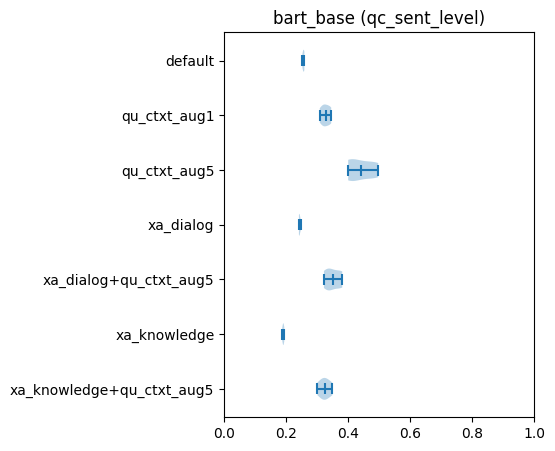

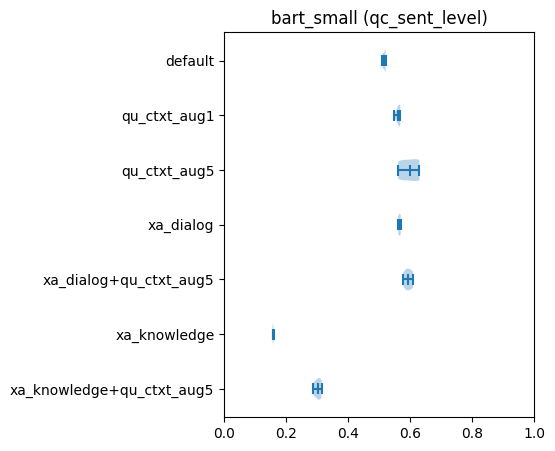

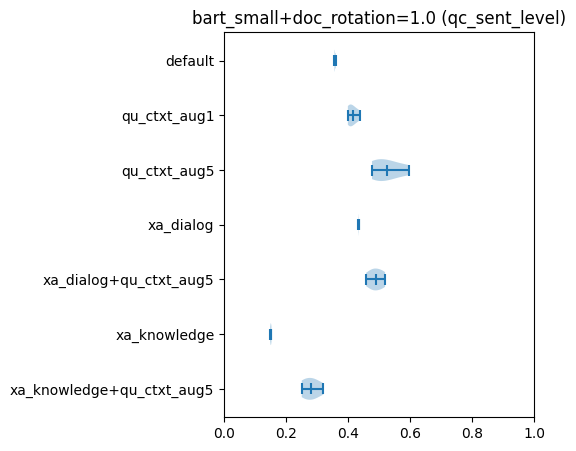

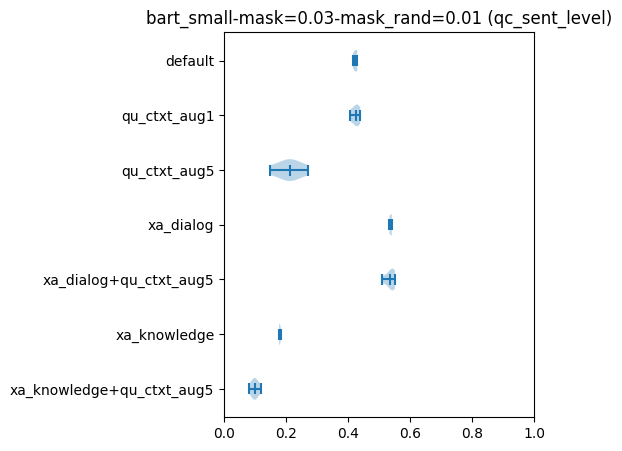

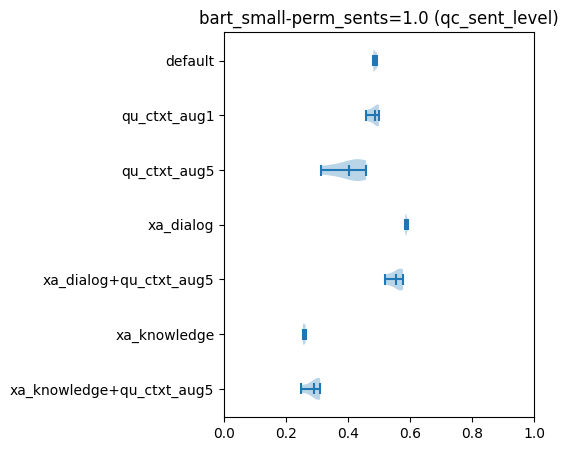

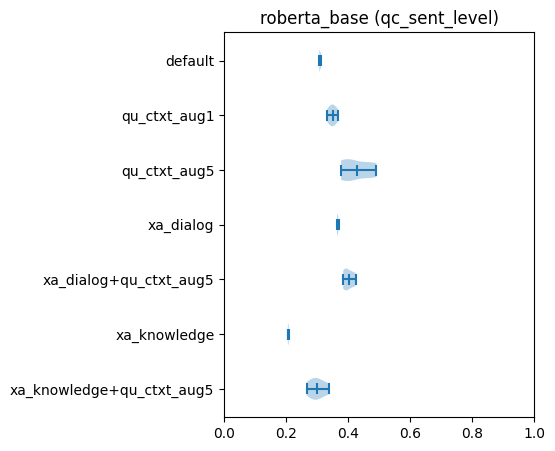

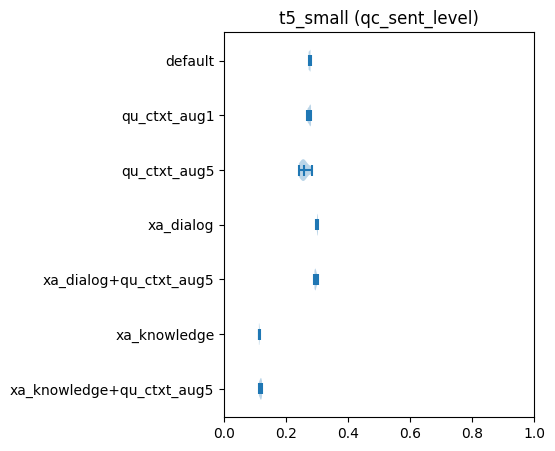

In [8]:
def build_violinplot(data: Dict, title: str, min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))

    if verbose:
        print('Data:', data)

    positions = range(1, len(data)+1)[::-1] # reveserse to have defualt at top
    labels = list(data.keys())[::-1] # reveserse to have defualt at top
    
    ax.violinplot(
        dataset = list(data.values()),
        positions=positions,
        points=30, widths=0.4,
        showmeans=True, showextrema=True, showmedians=False,
        vert=False,
    )

    # make title
    ax.set_title(title) 
    
    # label yaxis ticks
    ax.yaxis.set_tick_params(direction='out') 
    ax.yaxis.set_ticks_position('left')
    ax.set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#     ax.set_ylabel('Generation setting')
    
    # set xaxis limits
    min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
    max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
    print(f'min={min_val}, max={max_val}')
    ax.set_xlim(min_val, max_val) #, + 0.75)

    return fig

def build_violin_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

    # collect all the data for the relevant target metric first to set min and max vals for all plots
    data = {}
    for i, (model, dfx) in enumerate(df.groupby(level=0)):
        model_results = {}
        for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=1)):
            metric_scores = dfx[target_metric].values
            if min(metric_scores) < min_val:
                min_val = min(metric_scores)
            if max(metric_scores) > max_val:
                max_val = max(metric_scores)
            model_results[gen_setting] = metric_scores
        data[model] = model_results

    if verbose:
        print('Data:')
        print(data)
        
    # make violins for each model
    for model, results in data.items():
        fig = build_violinplot(results, f'{model} ({target_metric})', min_val, max_val, verbose=verbose)
        if save:
            outpath = str(paths['plots'] / f'{model}-{target_metric}.png')
            fig.savefig(outpath, dpi='figure', bbox_inches='tight')
            print(f'saved {outpath}')
    
    return

        
# build_violin_plots(df, target_metric='bleu_t', save=True, verbose=False)
# build_violin_plots(df, target_metric='bleu_t', save=True, verbose=False)
build_violin_plots(df, target_metric='qc_sent_level', save=True, verbose=False)

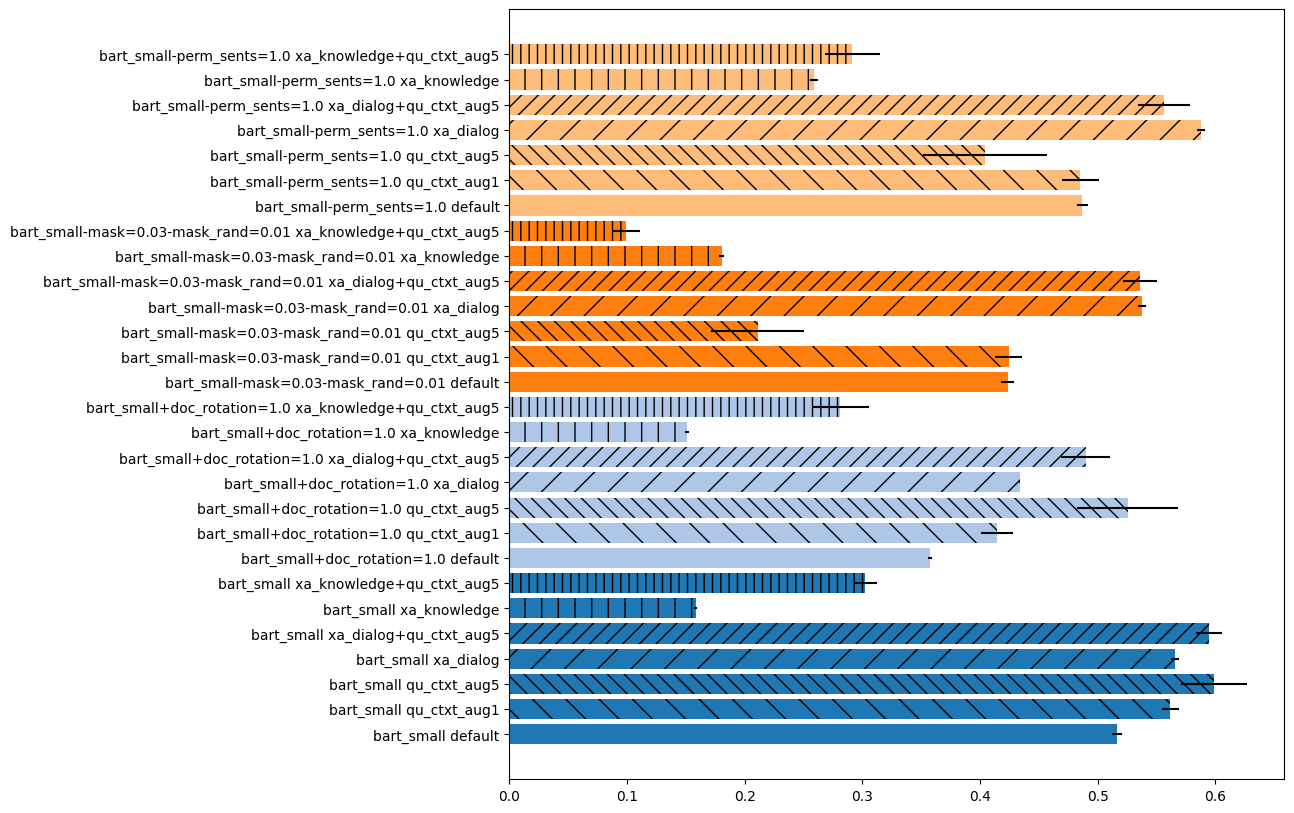

In [12]:
import matplotlib.colors as mcolors
colors = [mcolors.to_hex(plt.cm.tab20(i)) for i in range(20)]
# patterns = ['', '\\', '+', 'x', '.', '*', 'o', 'O',]
hpatterns = ['', '\\', '\\\\', '/', '//', '|', '||'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]
vpatterns = ['', '\\', '\\\\', '/', '//', '-', '--'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]

def build_bar_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', horizontal: bool = False, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

    # collect all the data for the relevant target metric first to set min and max vals for all plots
    data = {}
    for i, (model, dfx) in enumerate(df.groupby(level=0)):
        model_results = {}
        for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=1)):
            metric_scores = dfx[target_metric].values
            if min(metric_scores) < min_val:
                min_val = min(metric_scores)
            if max(metric_scores) > max_val:
                max_val = max(metric_scores)
            model_results[gen_setting] = metric_scores
        data[model] = model_results

    build_bar(data, horizontal=horizontal, verbose=verbose)
    
    return


def build_bar(data: Dict, horizontal: bool = True, verbose: bool = True):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    positions = []
    means = []
    stds = []
    bar_colors = []
    bar_patterns = []
    labels = []
    
    pos = 0
    for i, (model, gen_settings) in enumerate(data.items()):
        # TODO make groups for colors and build legend
        # https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
#                 group = {model: {}}
        for j, (gen_setting, scores) in enumerate(gen_settings.items()):

            labels.append(f'{model} {gen_setting}')
            
            if not horizontal:
                ax.bar(
                    x = pos,
                    height = scores.mean(),
                    yerr=scores.std(), 
                    color=colors[i],
                    hatch=vpatterns[j],
                    label=f'{model} {gen_setting}'
                )
            
            else:
                ax.barh(
                    y = pos,
                    width = scores.mean(),
                    xerr=scores.std(), 
                    color=colors[i],
                    hatch=hpatterns[j],
                    label=f'{model} {gen_setting}'
                )
            
            pos += 1 # incrememt pos for next bar
        
        if not horizontal:
            ax.set_xticks(np.arange(len(labels)), labels=labels, rotation=45)
        else:
            ax.set_yticks(np.arange(len(labels)), labels=labels)
#         ax.legend()
        
dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)

# dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)


